In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.layers as layers
from spektral.layers import GCNConv, GlobalSumPool
import spektral.data as data
from spektral.data import Dataset
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers
from framasToGraph import FramsTransformer
from framsfiles import reader as framsreader
import spektral
import os
import fnmatch
from GraphDataset import GraphDataset
from autoencoder import Encoder, DecoderX, DecoderA, VGAE
import matplotlib.pyplot as plt

PATH_FRAMS='/home/adam/Framsticks/Framsticks50rc19'
PATH_DATA ="graphs/gen/"


In [7]:
ADJ_SIZE = 15
NUM_FEATURES = 3
myData = GraphDataset(PATH_FRAMS, PATH_DATA,size_of_adj=ADJ_SIZE)
# dataset.apply(normalize_one())
loader = data.BatchLoader(myData, batch_size=32)
myData

Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data



GraphDataset(n_graphs=32000)

In [10]:
latent_dim = 128
n_hidden = 512
n_samples = 32

encoder = Encoder(latent_dim,n_hidden)
decoderA = DecoderA(ADJ_SIZE)
decoderX = DecoderX(latent_dim,ADJ_SIZE,NUM_FEATURES)
autoencoder = VGAE(encoder,decoderA,decoderX)

autoencoder.compile(optimizer=keras.optimizers.Adam())
losses_all = []


In [19]:
epochs = 1000
for _ in range(epochs):
    x,a = next(loader)
    loss = autoencoder.train_step([tf.convert_to_tensor(x),tf.convert_to_tensor(a)])
    losses_all.append(keras.backend.get_value(loss))

/home/adam/.local/lib/python3.7/site-packages/spektral/data/utils.py:198: UserWarning: `x` isn't a recognized object; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  shuffle_inplace(*data)


In [20]:
loss_all = [keras.backend.get_value(x['loss']) for x in  losses_all]
reconstruction_loss = [keras.backend.get_value(x['reconstruction_loss']) for x in  losses_all]
kl_loss = [keras.backend.get_value(x['kl_loss']) for x in  losses_all]

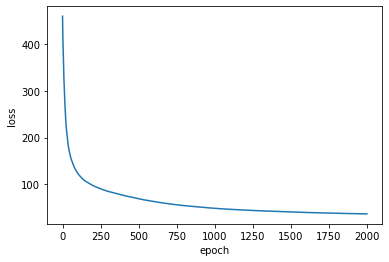

In [21]:
fig, ax = plt.subplots()

x = np.array(loss_all)
ax.plot(x)

ax.set(xlabel='epoch', ylabel='loss')
# ax.set_yscale('log')
# fig.savefig("test.png")
plt.show()

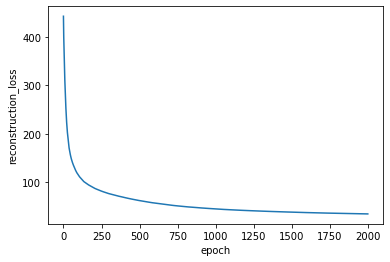

In [22]:
fig, ax = plt.subplots()

x = np.array(reconstruction_loss)
ax.plot(x)

ax.set(xlabel='epoch', ylabel='reconstruction_loss')
# ax.set_yscale('log')
# fig.savefig("test.png")
plt.show()

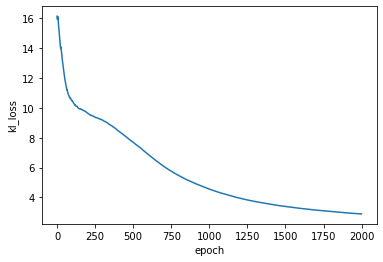

In [23]:
fig, ax = plt.subplots()

x = np.array(kl_loss)
ax.plot(x)

ax.set(xlabel='epoch', ylabel='kl_loss')
# ax.set_yscale('log')
# fig.savefig("test.png")
plt.show()

In [24]:
x,a = next(loader)
z_mean, z_log_var, z = autoencoder.encoder.predict([tf.convert_to_tensor(x),tf.convert_to_tensor(a)])
dec_a = autoencoder.decoderA.predict(z)
dec_x = autoencoder.decoderX(z,a)

In [25]:
i = 2
np.set_printoptions(precision=1,suppress=True)
print("TRUE A")
print(a[i])
print("RECONSTRUCTED A")
print(dec_a[i])

TRUE A
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
RECONSTRUCTED A
[[1.  0.8 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.7 1.  0.5 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.4 0.9 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.1 0.3 0.6 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.

In [26]:
np.set_printoptions(precision=3,suppress=True)
print("TRUE X")
print(x[i])
print("RECONSTRUCTED X")
print(dec_x[i])

TRUE X
[[ 0.     0.     0.   ]
 [ 0.043  0.     0.   ]
 [ 0.082  0.     0.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]]
RECONSTRUCTED X
tf.Tensor(
[[ 0.014 -0.     0.005]
 [ 0.026 -0.015 -0.001]
 [ 0.063 -0.001 -0.003]
 [-0.997 -0.997 -0.997]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]
 [-1.    -1.    -1.   ]], shape=(15, 3), dtype=float32)
